# Analysis and plots of the Stilling Response analysis for Musiclab Copenhagen

These are the final version of data and graphs.

This notebook produces figures corresponding to The Stilling Response paper. This notebook evaluates audience momtion at Stilling Points identified through the study of the chamber music performance. 

Note: The stillness points used in this analysis were finalised between December 9th to 11th, 2022. This third and final review of stilling points in the concert was to ensure tags were applied consistently. A few points were added to the previous sample and a couple removed, and some cue times were renegociated with reference to the first evaluation, again with the goal of ensuring consistency in stilling point criteria. These adjustments were conducted without any reference to the actual audience motion measurements at those specific moments. Additions were specifically of points that matched in tags and/or musical content to other points already in the set, the couple of removals were of points that no longer appeared to meet the explicit criteria. These changes raised the total number of stilling points from 249 to 257. At this time, we still do not presume these selections of stilling points are complete or indisputable. They seem to be a sufficient collection to demonstrate an interesting pattern, but are still far from the whole story. For examples of stilling points see the Music & Science paper. 

In [1]:
# import sys
import os
import time
import datetime as dt
# import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter,filtfilt
from scipy import interpolate
# from scipy.interpolate import interp1d
import pingouin as pg

from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size

In [2]:
pip show matplotlib | grep Version

Version: 3.8.3
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip show pandas | grep Version

Version: 2.1.2
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip show seaborn | grep Version

Version: 0.13.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip show pingouin | grep Version

Version: 0.5.4
Note: you may need to restart the kernel to use updated packages.


In [6]:
# NEW NO PD APPEND
def gap_nans(data,gap_t):
    # data is a pandas dataframe with columns called time and/or time_concert which is used to ID gaps greater than gap_T
    # gap_T is in milliseconds (ms)
    # rows of NaN data is added to non-time columns before the first sample, at edges of each gap, and after the last sample of data
    # these nans prevent interpolation errors through missing data
    cols = data.columns
    if 'time' in cols:
        time_col = 'time'
    if 'time_concert' in cols:
        time_col = 'time_concert'
        
    deltat = round(0.35*data[time_col].diff().median())
    dtdeltat =  pd.to_timedelta(deltat,unit = 'ms')
    dt = data[time_col].diff()    
    gapsi = np.array(dt[dt>gap_t].index)
    a = np.append(gapsi-1,dt.index[-1])
    gapsd = pd.DataFrame(index = a,columns = data.columns,dtype='float64') # why does pandas default to object data type?!
    for c in cols:
        if c.startswith('datetime'):
            gapsd[c] = data.loc[a,c]+dtdeltat
        if c.startswith('time'):
            gapsd[c] = data.loc[a,c]+deltat 

    a = np.append(gapsi,dt.index[0])
    gapsp = pd.DataFrame(index = a,columns = data.columns,dtype='float64')
    for c in cols:
        if c.startswith('datetime'):
            gapsp[c] = data.loc[a,c]-dtdeltat
        if c.startswith('time'):
            gapsp[c] = data.loc[a,c]-deltat 
    if len(gapsp)>0:
        data = pd.concat([gapsp,gapsd,data]).sort_values(time_col,ignore_index=True)
    return data

# Load Audience Motion files
These files are available on the OSF project, from the public Audience Data folder: https://osf.io/8t4rz/. Specifically files in the Participants and Timing folders and everything in the Audience Motion folders.

In [7]:
general_loc = '../'

public_mlmotion = general_loc + 'Public_data/Motion_ML/'
public_ax3 = general_loc +  'Public_data/Motion_AX3/'
public_Part = general_loc + 'Public_data/Participants/'
public_time = general_loc + 'Public_data/Timing/'

In [8]:
general_loc = '../'

public_mlmotion = general_loc + 'Audience_Data/Audience_Motion/Phone_Motion/'
public_ax3 = general_loc +  'Audience_Data/Audience_Motion/AX3_Motion/'
public_Part = general_loc + 'Audience_Data/Participants/'
public_time = general_loc + 'Audience_Data/Timing/'

In [9]:
concert_times = pd.read_csv(public_time +'Events_Main.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format

concert_times['sequence'] = concert_times.index
Main_concert_times = concert_times.set_index('Datetime')

In [10]:
# set the sampling period for the concert in UTC 
Start_time = pd.to_datetime('2021-10-26 17:30:00+0000').replace(tzinfo=None)
Synch_time = pd.to_datetime('2021-10-26 17:48:06+0000').replace(tzinfo=None)
Mid_time = pd.to_datetime('2021-10-26 19:00:00+0000').replace(tzinfo=None)
End_time = pd.to_datetime('2021-10-26 20:30:00+0000').replace(tzinfo=None)

# concert times 10 Hz
ts_ct = np.arange(-1086,9715, 0.1)*1000 
dt_ct = Synch_time + pd.to_timedelta(ts_ct,unit='ms')


concert_times = pd.read_csv(public_time +'Events_Full.csv',sep=",") #SV alignment for beeps
concert_times['Datetime']=(pd.to_datetime(concert_times['Datetime'])) # concert time stamps, confirm format
concert_times['sequence'] = concert_times.index
concert_times.set_index('Datetime',inplace = True)


Choose the audience to assess

In [11]:
#In hall participants
partDets = pd.read_csv(public_Part + 'Audience_Mapping_Public.csv')#,index_col = 0,header_col = 0)
# need only in person participants with aligned motion traces
partDets = partDets.loc[partDets['Attendance'].isin(['A']),:] # in person hall participant
alignedParts = partDets.loc[partDets['Motion_Quality'].isin(['Q','R']),:].reset_index(drop = True) # with aligned motion measurements
aligned_Part_Codes = list(alignedParts.Participant_Code.values)
#alignedParts

In [12]:
tic = time.time()
# load the motion traces 
# gather the aligned recordings for the live performance. Combining AX3 and ML data!
aud_df = pd.DataFrame(index = ts_ct,dtype='float64')
kept_dev = []
gap_t = 1000

for i,participant in alignedParts.iterrows():
    part = participant['Participant_Code']
    if part[2]=='Q': # Motionlab phone acc
        inst_d = pd.read_csv(public_mlmotion + part + '_Mobile_Motion.csv' )
    else: # AX3
        inst_d = pd.read_csv(public_ax3 + part + '_AX3_Motion.csv' )
    inst_d['datetime']=(pd.to_datetime(inst_d['datetime'])) # concert time stamps, confirm format
    datas = gap_nans(inst_d,1000)
    #get concert time
    resampled = pd.DataFrame(index = ts_ct)
    cols = datas.columns
    for col in cols[1:]:
        f = interpolate.interp1d(datas['time'], datas[col],fill_value='extrapolate')
        resampled[col] = f(ts_ct)
        
    # extract 1D accelerometer feature for easy comparison
    # and basic normalisation
    b = np.linalg.norm(resampled[['x','y','z']].diff().values,axis=1)
    
    if part[2]=='R': # aligned AX3 correction factor (basic but verified for low motion conditions)
        aud_df[part] = b.copy()*6 
    else:
        aud_df[part] = b.copy()
        
aud_df.index = dt_ct

print(time.time()-tic)

86.99564003944397


In [13]:
len(aud_df.columns)

85

In [14]:
aud_df.to_csv('./data/audience_motion.csv')

In [15]:
# aud_df = pd.read_csv('./data/audience_motion.csv',index_col=0)

In [16]:
Event_ranges = {'Beethoven 1':[8,9],'Beethoven 2':[9,10],'Beethoven 3':[10,11],'Beethoven 4':[11,12],'Schnittke 1':[17,18],'Schnittke 2':[18,19],'Schnittke 3':[19,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
Seg_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk':[33,51]}

aud_df.index = (ts_ct/1000).round(1)

seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]
[seg_start,seg_end ]


[57.4, 8042.24]

In [17]:
Event_ranges = {'Beethoven':[8,12],'Schnittke':[17,20],'Bach':[28,29],'Folk 1':[33,34],'Folk 2':[35,36],'Folk 3':[38,39],'Folk 4':[41,42],'Folk 5':[44,45],'Folk 6':[50,51]}
seg_df = aud_df.copy()
mov_df = pd.DataFrame(columns = seg_df.columns,index=Event_ranges.keys())
mus_df = pd.DataFrame(columns = seg_df.columns,dtype='float64')

for ev in Event_ranges:
    seg_start = Main_concert_times.iloc[Event_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Event_ranges[ev][1],0]
    mov_df.loc[ev,:] = seg_df.loc[seg_start:seg_end,:].copy().mean(skipna=True)
    mus_df  = pd.concat([mus_df,seg_df.loc[seg_start:seg_end,:].copy()])
music_index = mus_df.index

## quick check on missing data across audience motion recordings

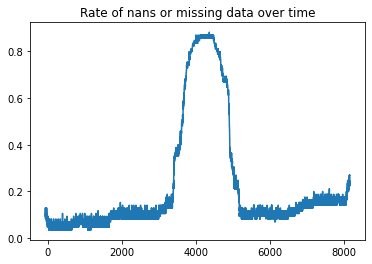

In [18]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[52,0]
nan_df = aud_df.loc[seg_start:seg_end].copy() 
nan_df.where(nan_df.isna(),0,inplace=True)
nan_df.mask(nan_df.isna(),1,inplace=True)
nan_df.mean(axis=1).plot()
plt.title('Rate of nans or missing data over time')
plt.show()

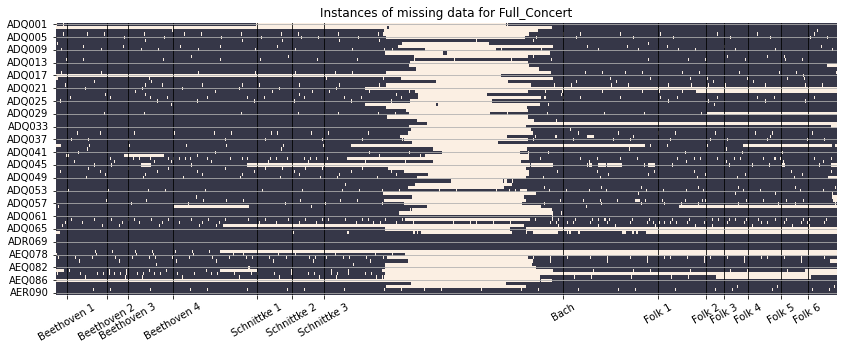

In [19]:
fig, (ax1) = plt.subplots(1, 1,figsize = [14,5])
chart = sns.heatmap(data=nan_df.transpose(), ax=ax1,vmin=0, vmax=1,cbar=False, alpha=0.8)
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
ax1.set_title('Instances of missing data for ' + seg_tag)
Music_xticks = len(nan_df)*(seg_times['Time_s'] - seg_start)/(seg_end-seg_start)
ax1.set_xticks(Music_xticks)
ax1.set_xticklabels(seg_times.Event)
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
ax1.grid()

plt.show()

# Load Stilling points
and audio features

In [20]:
# Stillings = pd.read_csv('./data/' + 'ReTagged_Stillings_with_Audio.csv')
Stillings = pd.read_csv('./data/' + 'Stilling_Points_Data.csv')

Stillings=Stillings.fillna(0)
Stillings= Stillings.set_index('TIME')
# add music column
Stillings['Music'] = 'Music'
for ev in Seg_ranges.keys():
    seg_start = Main_concert_times.iloc[Seg_ranges[ev][0],0]
    seg_end = Main_concert_times.iloc[Seg_ranges[ev][1],0]
    Stillings.loc[seg_start:seg_end,'Music'] = ev

seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]
[seg_start,seg_end ]
Still_times  = Stillings.loc[seg_start:seg_end].copy()
print(len(Still_times))
print(Stillings.columns)
Still_times.iloc[:5,:]

257
Index(['LABEL', 'Set', 'Movement', 'cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end',
       'OLDTIME', 'Music'],
      dtype='object')


,LABEL,Set,Movement,cues,Type,Gap,Rest,Connect,Voices_dec,Note_rate_dec,...,Rit,Fermata,Tempo_inc,Diminuendo,Fp/Fz,Cresc,Precision,end,OLDTIME,Music
TIME,,,,,,,,,,,,,,,,,,,,,
61.32,2.50,1,1,3.0,pause,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,61.32,Beethoven
65.84,4.50,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,65.84,Beethoven
79.02,10.25,1,1,3.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,79.02,Beethoven
88.75,13.00,1,1,3.0,close,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,88.26,Beethoven
95.79,17.50,1,1,4.0,dropin,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,95.78,Beethoven


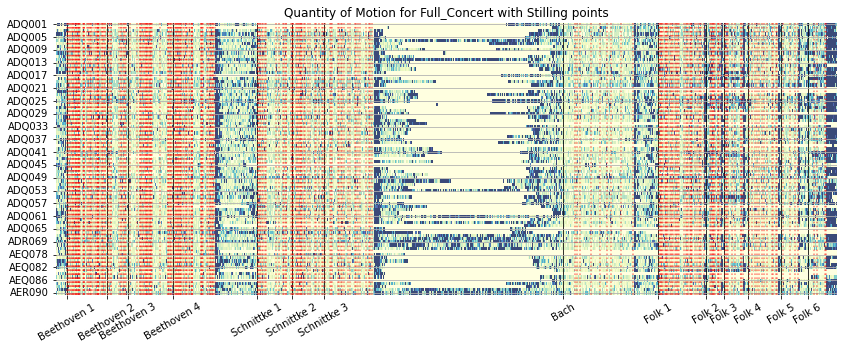

In [21]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[52,0]
seg_df = aud_df.loc[seg_start:seg_end].copy()
seg_df = seg_df.fillna(0)

fig, (ax1) = plt.subplots(1, 1,figsize = [14,5])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.8)
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)

for i in range(len(new_xticks)):
    ax1.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5)

ax1.set_title('Quantity of Motion for ' + seg_tag + ' with Stilling points')
Music_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end-seg_start)
ax1.set_xticks(Music_xticks)
ax1.set_xticklabels(seg_times.Event)
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
ax1.grid()

plt.show()

In [22]:
# audio features
SoundAmp = pd.read_csv('./data/ConcertStream_Audio_Amplitude_Envelop.csv')
# amplitude envelope output of sonic visualiser feature. Don't remember which but it shouldn't matter

SoundAmp = SoundAmp.set_index('TIME')

ts_ft = np.arange(0,8942, 0.1)#*1000 
reSound = pd.DataFrame(index = ts_ft)
f = interpolate.interp1d(SoundAmp.index, SoundAmp.VALUE,fill_value='extrapolate')
reSound['SoundAmp'] = f(ts_ft)/0.25

In [23]:
# V = pd.DataFrame(index = Stillings.index)
SF = reSound['SoundAmp']
pre = []
post = []
ch = []
for i in range(len(Stillings.index)): # reSound
    sm = Stillings.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime-3:Otime-2].mean()
    post_snip = SF.loc[Otime+0:Otime+1].mean()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)

Stillings['SoundAmp_pre'] = pre
Stillings['SoundAmp_post'] = post
Stillings['SoundAmp_shift'] = ch

In [24]:
SF = aud_df.median(axis=1)

pre = []
post = []
ch = []
for i in range(len(Stillings.index)):
    sm = Stillings.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime-3:Otime-2].median()
    post_snip = SF.loc[Otime+0:Otime+1].median()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)
Stillings['QoMmedian_pre'] = pre
Stillings['QoMmedian_post'] = post
Stillings['QoMmedian_shift'] = ch

pre = []
post = []
ch = []
for i in range(len(Stillings.index)):
    sm = Stillings.iloc[i,:]
    Otime = sm.name
    pre_snip = SF.loc[Otime-3:Otime-2].mean()
    post_snip = SF.loc[Otime+0:Otime+1].mean()
    pre.append(pre_snip)
    post.append(post_snip)
    ch.append(post_snip-pre_snip)

Stillings['QoMmean_pre'] = pre
Stillings['QoMmean_post'] = post
Stillings['QoMmean_shift'] = ch

In [25]:
# There is some correlation between the sound amplitude and median quantity of motion
# but this is not terribly informative. We can do better.
print(Main_concert_times.iloc[8,2])
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[12,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
print(sp.stats.pearsonr(seg_sound['SoundAmp'], seg_qom.median(axis=1)))
print(Main_concert_times.iloc[17,2])
seg_start = Main_concert_times.iloc[17,0]
seg_end = Main_concert_times.iloc[20,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
print(sp.stats.pearsonr(seg_sound['SoundAmp'], seg_qom.median(axis=1)))
print(Main_concert_times.iloc[28,2])
seg_start = Main_concert_times.iloc[28,0]
seg_end = Main_concert_times.iloc[29,0]
seg_qom = seg_df.loc[seg_start:seg_end].copy()
seg_sound = reSound.loc[seg_start:seg_end].copy()
print(sp.stats.pearsonr(seg_sound['SoundAmp'], seg_qom.median(axis=1)))


Beethoven 1
PearsonRResult(statistic=0.22763825510348057, pvalue=1.0755989316099592e-181)
Schnittke 1
PearsonRResult(statistic=0.2877919487266491, pvalue=8.186635726168132e-233)
Bach
PearsonRResult(statistic=0.0909791577050642, pvalue=3.5963718243842185e-15)


There is some correlation between the sound amplitude and median quantity of motion but this is not terribly informative. We can do better.

# Figures


## Intro and Methods


- Figure 1 Example excerpt of sound pressure level and median QoM with movement decrease calculation: Sound pressure level over indvidiual motion with intervals of comparison marked, lines connecting mean values per participant in pre and still onset with box plots and resultant ratio. Find moment with two instances to show? plot of decreasing ratios across all music and two points marked on distribution?

- Figure 2 (generated elsewhere) example stilling points.

- Table: stilling points per excerpt

[0.6973684210526315, 76, 53, 'm 5.5']
[0.4868421052631579, 76, 37, 'm 33.5']
[0.6973684210526315, 76, 53, 'm 49.0']
[0.5753424657534246, 73, 42, 'm 69.0']
[0.5675675675675675, 74, 42, 'm 77.5']
[0.6486486486486487, 74, 48, 'm 91.0']


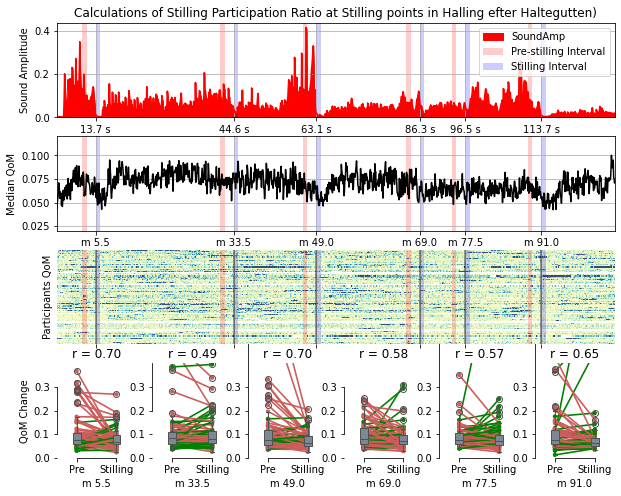

In [26]:
seg_tag = 'Folk 1'
seg_start = 6614.83+5 #Main_concert_times.iloc[33,0]
seg_end = seg_start+5 + 120 # Main_concert_times.iloc[34,0]
seg_qom = aud_df.loc[seg_start:seg_end].copy() 
Still_times  = Stillings.loc[seg_start:seg_end].copy()
Still_times['LABEL'] = [ 'm 5.5', 'm 33.5', 'm 49.0', 'm 69.0', 'm 77.5', 'm 91.0']
Still_times['LABEL_S'] = ['13.7 s','44.6 s','63.1 s','86.3 s','96.5 s','113.7 s']

seg_sound = reSound.loc[seg_start:seg_end].copy()
[seg_start,seg_end ]

fig, axs = plt.subplots(ncols=len(Still_times), nrows=4,figsize = [10,8])
gs = axs[0, 1].get_gridspec()

for ax in axs[0, :]: ax.remove()
axbig = fig.add_subplot(gs[0, :])
seg_sound.plot.area(ax=axbig,color='r')
axbig.set_xticks(Still_times.index)
axbig.set_xticklabels(Still_times['LABEL_S'])
axbig.set_xlim([seg_start,seg_end])
#axbig.set_xlabel('Time (s)')
axbig.set_ylabel('Sound Amplitude')
axbig.set_title('Calculations of Stilling Participation Ratio at Stilling points in Halling efter Haltegutten)')
axbig.grid()
yrange = [0,1]
k = 0
for ei in Still_times.index:
    if k==0:
        axbig.axvspan(ei-3, ei -2,yrange[0],yrange[1], facecolor='red', alpha=0.2,label ='Pre-stilling Interval')
        axbig.axvspan(ei, ei + 1,yrange[0],yrange[1], facecolor='blue', alpha=0.2,label =  'Stilling Interval')
        axbig.legend()
        k = 1
    else:
        axbig.axvspan(ei, ei + 1,yrange[0],yrange[1], facecolor='blue', alpha=0.2)
        axbig.axvspan(ei-3, ei -2,yrange[0],yrange[1], facecolor='red', alpha=0.2)


for ax in axs[1, :]: ax.remove()
axbig = fig.add_subplot(gs[1, :])
seg_df.median(axis=1).plot(ax=axbig,label='Median',color='k')
#axbig.set_title('Median Audience Quantity of motion at Stilling points')
axbig.set_ylim([0.02,0.12])
axbig.set_xlim([seg_start,seg_end])
axbig.set_xticks(Still_times.index)
axbig.set_xticklabels(Still_times.LABEL)
axbig.set_ylabel('Median QoM')
axbig.grid()

yrange = [0,1]
for ei in Still_times.index:
    axbig.axvspan(ei, ei + 1,yrange[0],yrange[1], facecolor='blue', alpha=0.2)
    axbig.axvspan(ei-3, ei -2,yrange[0],yrange[1], facecolor='red', alpha=0.2)

for ax in axs[2, :]: ax.remove()
axbig = fig.add_subplot(gs[2, :])
yrange = [0,90]
chart = sns.heatmap(data=seg_qom.transpose(), ax=axbig,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.8)
new_xticks = len(seg_qom)*(Still_times.index - seg_start)/(seg_end-seg_start)
a = Still_times.index.append(Still_times.index+1)
a = a.append(a-3).sort_values()
cue_ticks = len(seg_qom)*(a - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    axbig.plot([new_xticks[i],new_xticks[i]],yrange,'k',alpha=0.5)
    axbig.axvspan(cue_ticks[(i*4)+2], cue_ticks[(i*4)+3],yrange[0],yrange[1], facecolor='blue', alpha=0.2)
    axbig.axvspan(cue_ticks[(i*4)+0], cue_ticks[(i*4)+1],yrange[0],yrange[1], facecolor='red', alpha=0.2)
axbig.set_ylabel('Participants QoM')
axbig.set_yticks([])
axbig.set_xticks(new_xticks)
axbig.set_xticklabels([])
axbig.grid()
yrange = [0,80]
i = 0

for i in range(len(Still_times.index)):
    ei = Still_times.index[i]
    m1 = pd.DataFrame(columns=['PartID','Cond','QoM'])
    m1['PartID'] = seg_qom.columns
    m2 = m1.copy()
    m1['Cond']  = 'Pre'
    m1['QoM'] = seg_qom.loc[ei-3:ei-2].mean().values
    m2['Cond']  = 'Stilling'
    m2['QoM'] =  seg_qom.loc[ei:ei + 1].mean().values
    mQoM = pd.concat([m1,m2])
    pg.plot_paired(data=mQoM.loc[mQoM['QoM'].notna(),:], dv='QoM', within='Cond',
                    subject='PartID', ax=axs[3,i], boxplot_in_front=True)
    axs[3,i].set_ylim([0,0.4])
    axs[3,i].set_yticks([0,0.1,0.2,0.3])
    axs[3,i].set_ylabel('')
    axs[3,i].set_xlabel(Still_times.iloc[i,0])
    a = m2['QoM']-m1['QoM']
    r = (a<0).sum()/((a<0).sum()+(a>0).sum())
    axs[3,i].set_title('r = ' + f'{r:.2f}')
    print([r,((a<0).sum()+(a>0).sum()),(a<0).sum(),Still_times.iloc[i,0]])

axs[3,0].set_ylabel('QoM Change')
plt.savefig('./plots/mQoM_PreStilling_examples.png',bbox_inches = 'tight',dpi = 300)
plt.savefig('./plots/Fig1_Stilling_examples.pdf',bbox_inches = 'tight')

plt.show()


In [27]:
tag = 'Full Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[53,0]
Still_times  = Stillings.loc[seg_start:seg_end].copy()
print([tag,len(Still_times)])

tag = 'Beethoven'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[12,0]
Still_times  = Stillings.loc[seg_start:seg_end].copy()
print([tag,len(Still_times)])

tag = 'Schnittke'
seg_start = Main_concert_times.iloc[17,0]
seg_end = Main_concert_times.iloc[20,0]
Still_times  = Stillings.loc[seg_start:seg_end].copy()
print([tag,len(Still_times)])

tag = 'Bach'
seg_start = Main_concert_times.iloc[28,0]
seg_end = Main_concert_times.iloc[29,0]
Still_times  = Stillings.loc[seg_start:seg_end].copy()
print([tag,len(Still_times)])

tag = 'Folk'
seg_start = Main_concert_times.iloc[33,0]
seg_end = Main_concert_times.iloc[51,0]
Still_times  = Stillings.loc[seg_start:seg_end].copy()
print([tag,len(Still_times)])


['Full Concert', 257]
['Beethoven', 120]
['Schnittke', 54]
['Bach', 9]
['Folk', 74]


## Analysis 1: Distribution of decrease, Still and Stiller
    Distribution of decreases across all music and across stilling points
    Still vs stiller points
    Median median time series at these stiller points, timing argument across all points


In [28]:
preoff = -3
postoff = 0

In [29]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[53,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].copy()
Still_times  = Stillings.loc[seg_start:seg_end].copy()


In [30]:
# decreases for all music, include nans
V_df = pd.DataFrame(index = music_index)
seg_df = aud_df.copy()
k=[]
qm1 = []
qm2 = []
for i in music_index:
    pre_snip_df = seg_df.loc[i+preoff:i+preoff+1.0].mean(axis=0).values
    post_snip_df = seg_df.loc[i+postoff:i+postoff+1].mean(axis=0).values
    Se=post_snip_df - pre_snip_df
    k.append((Se<0).sum()/((Se<0).sum()+(Se>0).sum()))
    qm1.append(np.nanmedian(pre_snip_df))
    qm2.append(np.nanmedian(post_snip_df))
V_df['Ratio'] = k
V_df['QoM-pre'] = qm1
V_df['QoM-post'] = qm2
print([np.median(np.array(k)),np.std(np.array(k))])

[0.5068493150684932, 0.06838747503602431]


In [31]:
V_df.to_csv('./data/Music_Index_qom_pre_stillings.csv')

In [32]:
V_df=pd.read_csv('./data/Music_Index_qom_pre_stillings.csv',index_col = 0)
print(len(V_df))
V_df.iloc[:5,:]

50630


,Ratio,QoM-pre,QoM-post
57.4,0.658228,0.083970,0.076385
57.5,0.645570,0.083611,0.076428
57.6,0.612500,0.081471,0.075533
57.7,0.587500,0.085132,0.076191
57.8,0.562500,0.084802,0.079118


In [33]:
# exclusively music interval
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[51,0]
[seg_start,seg_end ]
Still_times  = Stillings.loc[seg_start:seg_end].copy()

V = pd.DataFrame(columns = seg_df.columns)
k = []
for i in range(len(Still_times)):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip_df = seg_df.loc[Otime+preoff:Otime+preoff+1.0].mean(axis=0).values
    post_snip_df = seg_df.loc[Otime+postoff:Otime+postoff+1.0].mean(axis=0).values
    Se=post_snip_df - pre_snip_df
    V.loc[Otime,:] = Se
    k.append((Se<0).sum()/((Se<0).sum()+(Se>0).sum())) # excluding nans from difference
Still_times['Ratio'] = k
print([np.median(np.array(k)),np.std(np.array(k))])

[0.5432098765432098, 0.08116458798492059]


In [34]:
# full concert after synch taps
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[53,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].copy()
W = pd.DataFrame(columns = seg_df.columns)
k = []
for i in range(len(Still_times)):
    sm = Still_times.iloc[i,:]
    Otime = sm.name
    pre_snip_df = seg_df.loc[Otime+preoff:Otime+preoff+1.0].mean(axis=0).values
    post_snip_df = seg_df.loc[Otime+postoff:Otime+postoff+1.0].mean(axis=0).values
    Se=post_snip_df - pre_snip_df
    W.loc[Otime,:] = Se
W.iloc[:5,:]

,ADQ001,ADQ002,ADQ003,ADQ004,ADQ005,ADQ006,ADQ007,ADQ008,ADQ009,ADQ010,...,AEQ081,AEQ082,AEQ083,AEQ084,AEQ085,AEQ086,AEQ087,AEQ088,AEQ089,AER090
61.32,0.021538,NaN,0.003819,0.002232,-0.000457,-0.028363,0.031912,0.00438,NaN,0.086102,...,0.005375,0.035915,0.000453,0.017885,-0.014291,NaN,0.011674,-0.000509,-0.03389,-0.013935
65.84,-0.007778,NaN,0.017653,0.025179,0.003027,0.009729,-0.0267,0.038012,-0.021257,0.023942,...,0.059119,-0.155959,0.000983,-0.004148,-0.00805,NaN,0.008135,-0.018025,-0.001429,-0.037794
79.02,0.010744,NaN,-0.025797,-0.005922,0.015097,-0.035748,0.029594,-0.004195,-0.011245,-0.029619,...,0.016585,-0.187859,-0.005053,NaN,-0.055238,NaN,0.143796,-0.011103,-0.016263,-0.014585
88.75,0.007311,NaN,0.028724,0.005948,-0.034414,-0.012913,0.005012,-0.006973,-0.004926,-0.01496,...,0.003937,0.026035,-0.00611,0.001534,0.014745,NaN,-0.04446,0.012956,-0.024511,0.002438
95.79,-0.0059,NaN,-0.021136,0.061923,0.06256,-0.000994,-0.012989,-0.017246,0.005376,-0.038487,...,-0.009046,0.01395,0.00314,0.010242,0.007237,NaN,-0.006227,-0.053424,0.074571,0.027913


In [35]:
Still_times.columns

Index(['LABEL', 'Set', 'Movement', 'cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end',
       'OLDTIME', 'Music', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'QoMmedian_pre', 'QoMmedian_post', 'QoMmedian_shift', 'QoMmean_pre',
       'QoMmean_post', 'QoMmean_shift', 'Ratio'],
      dtype='object')

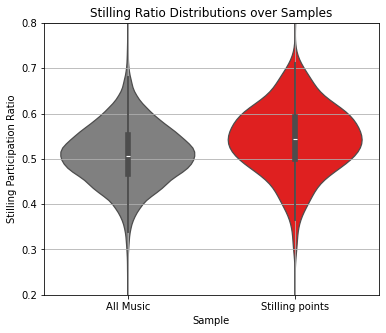

In [36]:
A = V_df.loc[:,['Ratio']].copy()
A['Sample'] = 'All Music'
B = Still_times.loc[:,['Ratio']].copy()
B.loc[:,'Sample'] = 'Stilling points'
df = pd.concat([A,B],axis = 0)

fig, axs = plt.subplots(1,1,figsize=[6,5])

cpalette = {'All Music':'grey','Stilling points':'r'}

sns.violinplot(data=df, x="Sample", y="Ratio",hue = "Sample",
               legend=False,palette = cpalette,ax=axs)
plt.title('Stilling Ratio Distributions over Samples')
plt.ylabel('Stilling Participation Ratio')
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.grid()
plt.ylim([0.2,0.8])

plt.savefig('./plots/All_Music_part_ratios_violin.png',bbox_inches = 'tight',dpi = 300)
plt.savefig('./plots/Fig3_SRP_violinplot.pdf',bbox_inches = 'tight',dpi = 300)

plt.show()

In [37]:
print([Still_times.loc[:,'Ratio'].median(),V_df.loc[:,'Ratio'].median()])
sp.stats.ks_2samp(Still_times.loc[:,'Ratio'], V_df.loc[:,'Ratio'], alternative='less')

[0.5432098765432098, 0.5068493150684932]


KstestResult(statistic=0.21561507880088315, pvalue=4.091292492051354e-11, statistic_location=0.5294117647058824, statistic_sign=-1)

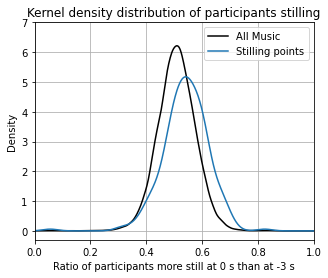

In [38]:
V_df.loc[:,'Ratio'].plot.kde(label='All Music',color='k',figsize=[5,4])
Still_times.loc[:,'Ratio'].plot.kde(label='Stilling points')
plt.legend()
plt.title('Kernel density distribution of participants stilling')
plt.xlabel('Ratio of participants more still at 0 s than at -3 s')
plt.grid()
plt.xlim([0,1])
plt.ylim([-0.3,7])
plt.savefig('./plots/All_Stillings_part_ratios_dke.png',dpi = 300)
plt.show()

In [39]:
sum(V_df.loc[:,'Ratio']<Still_times.loc[:,'Ratio'].median())/len(V_df.loc[:,'Ratio'])

0.6963657910329843

The likelihood of a participant decreasing in their movements at stilling points is greater than any random point in the music. 50% of stilling points feature more motion decreases than 70% of time music is being presented. That's not a huge difference, but it's robust, suggesting there is something about these stilling points that are more encouraging of stillness than any given moment of music. 

These stilling points are not forcing cooperative changes in motion in across the entire audience. These shifts in quantity of motion are small and the ratios suggest that around the constant noise of some moving more and some moving less, only a small subset can be assumed to be shifting behaviour in response to whatever makes a "stilling" point. 

Since this much has been demonstrated, that there is something about stilling points that encourage (lightly) the audience to be more still in aggregage, we can turn the data around to see if there are any particular qualities or differences between those points that are more influential vs less. Those points with higher than median participation are here refered to as "stiller" points. 

### Stiller points
Let's allow that my definition of stilling points is flawed, including moments that maybe do not have the impact hypothesised. From the measured response pattern we can define a subset of points that show the expected effect, the "stiller points" with a majority of participants decreasing in motion into these moments. 

We still can not assume everyone is responding to the musical qualities that prompted the moment to be selected in the initial stilling point assessment, but it does give a subset of moments with some likely shared influence on how the audience behaved. Comparing stilling points to stiller points may illucidate the phenomenon of interest. 


In [40]:
thresh = V_df.loc[:,'Ratio'].median() # median of stilling ratio across whole intervals of recording
Part_Still = Still_times.loc[Still_times['Ratio']>thresh,:]

Part_UnStill = Still_times.loc[Still_times['Ratio']<=thresh,:]
print([len(Part_Still),len(Part_Still)/len(Still_times), Part_Still['Ratio'].mean()])
print([len(Part_UnStill),len(Part_UnStill)/len(Still_times), Part_UnStill['Ratio'].mean()])

[174, 0.6770428015564203, 0.5819943983901174]
[83, 0.3229571984435798, 0.4542713041916231]


In [41]:
Stills_Pieces = pd.DataFrame()
Stills_Pieces['Stilling'] =Still_times['Music'].value_counts()
Stills_Pieces['Stiller'] = Part_Still['Music'].value_counts()
Stills_Pieces['R_stilled'] = Stills_Pieces.loc[:,"Stiller"]/Stills_Pieces.loc[:,"Stilling"]
Stills_Pieces

,Stilling,Stiller,R_stilled
Music,,,
Beethoven,120,83,0.691667
Folk,74,47,0.635135
Schnittke,54,37,0.685185
Bach,9,7,0.777778


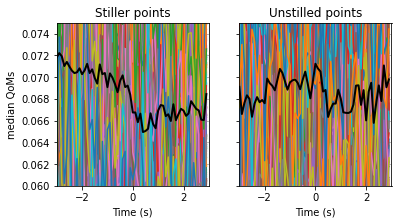

In [42]:
# extract the distribution of average movement in some seconds before each still time and in/after
medianQM = seg_df.median(axis=1,skipna = True)

snips = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_Still.index)
snips2 = pd.DataFrame(index = np.arange(-3,3, 0.1),columns = Part_UnStill.index)
for i in range(len(Part_Still)-1):
    sm = Part_Still.iloc[i,:]
    Otime = sm.name
    snips.loc[:,Otime]=medianQM.loc[Otime-3.025:Otime+2.975].values
    
for i in range(len(Part_UnStill)-1):
    sm = Part_UnStill.iloc[i,:]
    Otime = sm.name
    snips2.loc[:,Otime]=medianQM.loc[Otime-3.025:Otime+2.975].values
        
f, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
yrange = [0.06,0.075]
xrange = [-3,3]
ax=ax1
snips.plot(legend = False,ax=ax)
snips.median(axis=1).plot(color = 'k',linewidth=2,legend = False,ax=ax)
ax.set_title('Stiller points')
ax.set_ylim(yrange)
ax.set_xlim(xrange)
ax.set_ylabel('median QoMs')
ax.set_xlabel('Time (s)')
ax.grid()

ax=ax2
snips2.plot(legend = False,ax=ax)
snips2.median(axis=1).plot(color = 'k',linewidth=2,legend = False,ax=ax)
ax.set_title('Unstilled points')
ax.set_yticklabels([])
ax.set_ylim(yrange)
ax.set_xlim(xrange)
ax.set_xlabel('Time (s)')
ax.grid()


plt.savefig('./plots/Stiller_QoM_Medians_with_ends.png',bbox_inches = 'tight',dpi = 300)
plt.savefig('./plots/Fig4_QoM_MedianTS.pdf',bbox_inches = 'tight',dpi = 300)

plt.show()


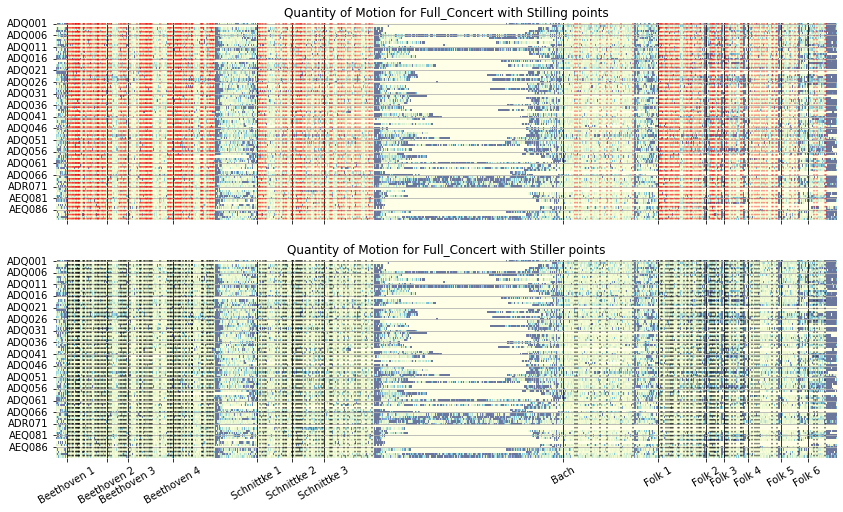

In [43]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[52,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
# .rolling(10).mean()[::10] cut down to 1 hz? 2 hz?
seg_df = aud_df.loc[seg_start:seg_end].rolling(5).mean()[::5].copy()
seg_df = seg_df.fillna(0)

fig, (ax1,ax2) = plt.subplots(2, 1,figsize = [14,8])

chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    ax1.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5)
ax1.set_title('Quantity of Motion for ' + seg_tag + ' with Stilling points')
Music_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end-seg_start)
ax1.set_xticks(Music_xticks)
ax1.set_xticklabels([])
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
ax1.grid()
chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)
new_xticks = len(seg_df)*(Part_Still.index - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    ax2.plot([new_xticks[i],new_xticks[i]],[0,90],':k',alpha=0.6)

ax2.set_title('Quantity of Motion for ' + seg_tag + ' with Stiller points')
ax2.set_xticks(Music_xticks)
ax2.set_xticklabels(seg_times.Event)
ax2.tick_params(axis='x',grid_color='k',labelrotation=30)
ax2.grid()
plt.savefig('./plots/Hall_qom_More_stilledpoints.png',bbox_inches = 'tight',dpi = 300)
# plt.savefig('./plots/Fig7_Stilling_Stiller_Stilled_QoM.pdf',bbox_inches = 'tight',dpi = 300)

plt.show()

In [44]:
tags_bi = ['Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end']

tags_all = ['cues', 'Type', 'Gap', 'Rest', 'Connect',
       'Voices_dec', 'Note_rate_dec', 'Drone', 'TextInc', 'Phr_end',
       'Phr_begining', 'Elide', 'Sequence', 'Rubato', 'Rit', 'Fermata',
       'Tempo_inc', 'Diminuendo', 'Fp/Fz', 'Cresc', 'Precision', 'end',
       'OLDTIME', 'Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
       'QoMmean_pre','QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 
       'QoMmedian_post','QoMmedian_shift', 'Music']

tags_quant = ['cues','Ratio', 'SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',
              'QoMmean_pre', 'QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre',
              'QoMmedian_post','QoMmedian_shift']

tags_cat = ['LABEL','Set','Movement','Type','Music']

Feat_stats = pd.DataFrame(index = Part_Still.columns)

A = Still_times[tags_bi].astype('bool').sum()
Feat_stats.loc[A.index,"All Stillings"] = A

A = Still_times[tags_quant].mean()
Feat_stats.loc[A.index,"All Stillings"] = A

A = Part_Still[tags_bi].sum()
Feat_stats.loc[A.index,"Stiller"] = A

A = Part_Still[tags_quant].mean()
Feat_stats.loc[A.index,"Stiller"] = A

A = Part_UnStill[tags_bi].sum()
Feat_stats.loc[A.index,"Unstilled"] = A

A = Part_UnStill[tags_quant].mean()
Feat_stats.loc[A.index,"Unstilled"] = A

Feat_stats['R_stilled'] = Feat_stats.loc[:,"Stiller"]/Feat_stats.loc[:,"All Stillings"]


In [45]:
Feat_stats

,All Stillings,Stiller,Unstilled,R_stilled
LABEL,NaN,NaN,NaN,NaN
Set,NaN,NaN,NaN,NaN
Movement,NaN,NaN,NaN,NaN
cues,1.077821,1.068966,1.096386,0.991784
Type,NaN,NaN,NaN,NaN
Gap,138.000000,98.000000,40.000000,0.710145
Rest,95.000000,68.000000,27.000000,0.715789
Connect,122.000000,78.000000,44.000000,0.639344
Voices_dec,130.000000,84.000000,46.000000,0.646154
Note_rate_dec,57.000000,40.000000,17.000000,0.701754


While the sampling of tags is every uneven, we can check if some of the stilling cues are more reliable in producing or preventing stilling.

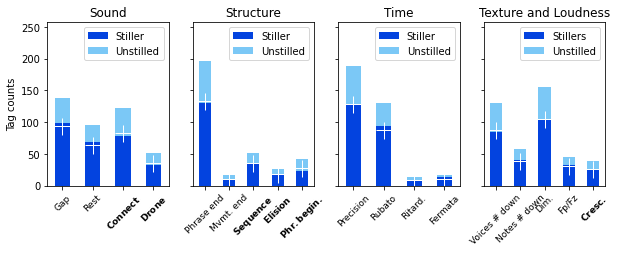

In [46]:
feats_sound = ['Gap', 'Rest', 'Connect', 'Drone',]
feats_texture_loudness = ['Voices_dec', 'Note_rate_dec','Diminuendo', 'Fp/Fz', 'Cresc']
feats_structure = ['Phr_end','end','Sequence', 'Elide','Phr_begining', ]
feats_tempo = ['Precision','Rubato', 'Rit', 'Fermata',]
feats_ampli = ['SoundAmp_pre', 'SoundAmp_post', 'SoundAmp_shift',]
feats_qom = ['QoMmean_pre','QoMmean_post', 'QoMmean_shift', 'QoMmedian_pre', 'QoMmedian_post','QoMmedian_shift','Ratio']

marker_style = dict(linestyle='', color='1.0', markersize=17,)
width = 0.5

f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(10,3))
ax = ax1
feats_set = feats_sound
feats_subtag = ['Gap','Rest',"$\\bf{Connect}$","$\\bf{Drone}$"]
ax.bar(feats_set,Feat_stats.loc[feats_set,"Stiller"], width,label="Stiller",color='xkcd:blue')
ax.bar(feats_set,Feat_stats.loc[feats_set,"Unstilled"], width,bottom=Feat_stats.loc[feats_set,"Stiller"],label="Unstilled",color='xkcd:lightblue')
ax.plot(Feat_stats.loc[feats_set,"All Stillings"]*0.677, marker='+', **marker_style)
ax.set_xticks(np.arange(len(feats_set)))
ax.set_xticklabels(feats_subtag,fontsize=9)
ax.set_title('Sound')
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,len(Still_times)])
ax.legend(loc="best")
ax.set_ylabel('Tag counts')
ax.tick_params(axis='x',labelrotation=45)

ax = ax2
feats_set = feats_structure
feats_subtag = ['Phrase end',"Mvmt. end","$\\bf{Sequence}$","$\\bf{Elision}$","$\\bf{Phr. begin.}$"]
ax.bar(feats_set,Feat_stats.loc[feats_set,"Stiller"], width,label="Stiller",color='xkcd:blue')
ax.bar(feats_set,Feat_stats.loc[feats_set,"Unstilled"], width,bottom=Feat_stats.loc[feats_set,"Stiller"],label="Unstilled",color='xkcd:lightblue')
ax.plot(Feat_stats.loc[feats_set,"All Stillings"]*0.677, marker='+', **marker_style)
ax.set_xticks(np.arange(len(feats_set)))
ax.set_xticklabels(feats_subtag)
ax.set_title('Structure')
ax.legend(loc="best")
ax.set_yticklabels([])
ax.set_xticklabels(feats_subtag,fontsize=9)
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,len(Still_times)])
ax.tick_params(axis='x',labelrotation=45)

ax = ax3
feats_set = feats_tempo
feats_subtag = ['Precision','Rubato', 'Ritard.', 'Fermata', ]
ax.bar(feats_set,Feat_stats.loc[feats_set,"Stiller"], width,label="Stiller",color='xkcd:blue')
ax.bar(feats_set,Feat_stats.loc[feats_set,"Unstilled"], width,bottom=Feat_stats.loc[feats_set,"Stiller"],label="Unstilled",color='xkcd:lightblue')
ax.plot(Feat_stats.loc[feats_set,"All Stillings"]*0.677, marker='+', **marker_style)
ax.set_xticks(np.arange(len(feats_set)))
ax.set_xticklabels(feats_subtag)
ax.set_title('Time')
ax.legend(loc="best")
ax.set_yticklabels([])
ax.set_xticklabels(feats_subtag,fontsize=9)
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,len(Still_times)])
ax.tick_params(axis='x',labelrotation=45)

ax = ax4
feats_set = feats_texture_loudness
feats_subtag =['Voices # down', 'Notes # down','Dim.', 'Fp/Fz', "$\\bf{Cresc.}$",]
ax.bar(feats_set,Feat_stats.loc[feats_set,"Stiller"], width,label="Stillers",color='xkcd:blue')
ax.bar(feats_set,Feat_stats.loc[feats_set,"Unstilled"], width,bottom=Feat_stats.loc[feats_set,"Stiller"],label="Unstilled",color='xkcd:lightblue')
ax.plot(Feat_stats.loc[feats_set,"All Stillings"]*0.677, marker='+', **marker_style)
ax.set_xticks(np.arange(len(feats_set)))
ax.set_xticklabels(feats_subtag)
ax.set_title('Texture and Loudness') 
ax.legend(loc="best")
ax.set_yticklabels([])
ax.set_xticklabels(feats_subtag,fontsize=9)
ax.set_xlim([-0.5,len(feats_set)-0.5])
ax.set_ylim([0,len(Still_times)])
ax.tick_params(axis='x',labelrotation=45)


plt.savefig('./plots/Tags_Stiller_Ratio_sep.png', bbox_inches = 'tight',dpi = 300)
plt.savefig('./plots/Fig5_Tags_stiller.pdf',bbox_inches = 'tight',dpi = 300)
plt.show()

## Analysis 2: Stiller and the lower limit of measurable motion 

    stiller vs less still points per tag/feature
    mQoM pre and at still points for all stilling, stiller, and less still points
    What proportion of music listening is under this threshold?
    Full concert motion with stiller points and min motion points.


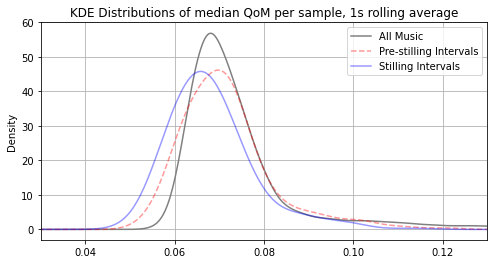

In [47]:
medianQM_Roll = mus_df.rolling(10).mean().median(axis=1)
f, ax = plt.subplots(1,1,figsize=[8,4])
medianQM_Roll.plot.kde(label='All Music',color='grey',ax=ax)
Still_times.loc[:,'QoMmedian_pre'].plot.kde(label='Pre-stilling Intervals',color='red',linestyle='dashed',alpha = 0.4, ax=ax)
Still_times.loc[:,'QoMmedian_post'].plot.kde(label='Stilling Intervals',color='blue',alpha = 0.4, ax=ax)

plt.legend()
plt.title('KDE Distributions of median QoM per sample, 1s rolling average')
plt.grid()
plt.xlim([0.03,0.13])
plt.ylim([-3,60])
plt.savefig('./Plots/All_Stillings_medQoM_dke.png',dpi = 300)

plt.show()

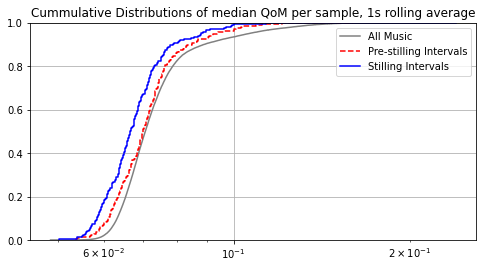

In [48]:
medianQM_Roll = mus_df.rolling(10).mean().median(axis=1)
f, ax = plt.subplots(1,1,figsize=[8,4])
ax.ecdf(medianQM_Roll[medianQM_Roll.notna()],color='grey',label="All Music")
ax.ecdf(Still_times.loc[:,'QoMmedian_pre'],color='red',linestyle='dashed',label="Pre-stilling Intervals")
ax.ecdf(Still_times.loc[:,'QoMmedian_post'],color='blue',label="Stilling Intervals")

plt.legend()
plt.title('Cummulative Distributions of median QoM per sample, 1s rolling average')
plt.grid()
ax.set_xscale('log')
plt.savefig('./Plots/All_Stillings_medQoM_cdf.png',dpi = 300)

plt.show()

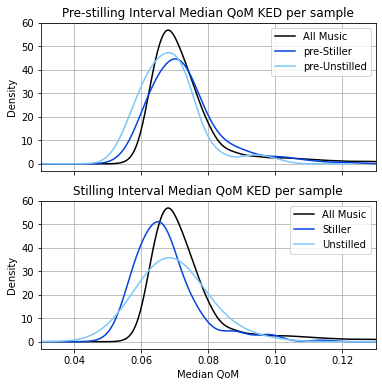

In [49]:
Part_times = Part_Still.copy()
medianQM_Roll = mus_df.rolling(10).mean().median(axis=1)
f, (ax1,ax2) = plt.subplots(2,1,figsize=[6,6])

ax = ax1
medianQM_Roll.plot.kde(label='All Music',color='black',ax=ax)
Part_times.loc[:,'QoMmedian_pre'].plot.kde(label='pre-Stiller',color='xkcd:blue',ax=ax)
Part_UnStill.loc[:,'QoMmedian_pre'].plot.kde(label='pre-Unstilled',color='xkcd:lightblue',ax=ax)
ax.legend()
ax.set_title('Pre-stilling Interval Median QoM KED per sample')
ax.set_xticklabels([])
ax.grid()
ax.set_xlim([0.03,0.13])
ax.set_ylim([-3,60])

ax = ax2
medianQM_Roll.plot.kde(label='All Music',color='black',ax=ax)
Part_times.loc[:,'QoMmedian_post'].plot.kde(label='Stiller',color='xkcd:blue',ax=ax)
Part_UnStill.loc[:,'QoMmedian_post'].plot.kde(label='Unstilled',color='xkcd:lightblue',ax=ax)
ax.legend()
ax.set_title('Stilling Interval Median QoM KED per sample')
ax.grid()
ax.set_xlim([0.03,0.13])
ax.set_ylim([-3,60])
ax.set_xlabel('Median QoM')

plt.savefig('./plots/All_Stillings_Stillers_medQoM_dke.png',bbox_inches = 'tight',dpi = 300)
plt.savefig('./plots/Fig6_MedQoM_dke.pdf',bbox_inches = 'tight',dpi = 300)

plt.show()

KS test of distribution difference between QoM at pre-Stiller and All Music
KS stat =  0.06  p =  0.4954
KS test of distribution difference between QoM at pre-Unstilled and All Music
KS stat =  0.21  p =  0.0009


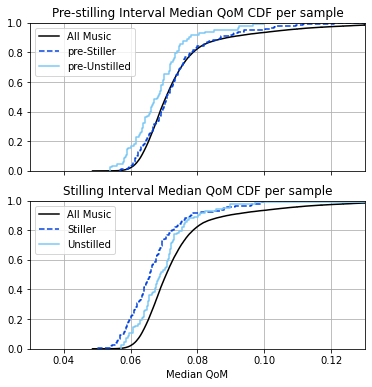

KS test of distribution difference between QoM at Stiller and All Music
KS stat =  0.3  p =  0.0
KS test of distribution difference between QoM at Unstilled and All Music
KS stat =  0.15  p =  0.037


In [50]:
Part_times = Part_Still.copy()
medianQM_Roll = mus_df.rolling(10).mean().median(axis=1)
f, (ax1,ax2) = plt.subplots(2,1,sharex = True,sharey = True, figsize=[6,6])

ax = ax1
ax.ecdf(medianQM_Roll[medianQM_Roll.notna()],color='black',label="All Music")
ax.ecdf(Part_times.loc[:,'QoMmedian_pre'],linestyle='dashed',label='pre-Stiller',color='xkcd:blue')
ax.ecdf(Part_UnStill.loc[:,'QoMmedian_pre'],label='pre-Unstilled',color='xkcd:lightblue')
ax.legend()
ax.set_title('Pre-stilling Interval Median QoM CDF per sample')
ax.grid(which='minor',axis='x',linestyle='dotted')
ax.grid(which='major',axis='both',linestyle='-')

print(' '.join(['KS test of distribution difference between QoM at','pre-Stiller','and',"All Music"]))
st = sp.stats.ks_2samp(Part_times.loc[:,'QoMmedian_pre'], medianQM_Roll[medianQM_Roll.notna()])
print(' '.join(['KS stat = ',str(st.statistic.round(2)),' p = ',str(st.pvalue.round(4))]))
print(' '.join(['KS test of distribution difference between QoM at','pre-Unstilled','and',"All Music"]))
st = sp.stats.ks_2samp(Part_UnStill.loc[:,'QoMmedian_pre'], medianQM_Roll[medianQM_Roll.notna()])
print(' '.join(['KS stat = ',str(st.statistic.round(2)),' p = ',str(st.pvalue.round(4))]))

ax = ax2
ax.ecdf(medianQM_Roll[medianQM_Roll.notna()],color='black',label="All Music")
ax.ecdf(Part_times.loc[:,'QoMmedian_post'],linestyle='dashed',label='Stiller',color='xkcd:blue')
ax.ecdf(Part_UnStill.loc[:,'QoMmedian_post'],label='Unstilled',color='xkcd:lightblue')
ax.legend()
ax.set_title('Stilling Interval Median QoM CDF per sample')
ax.grid(which='minor',axis='x',linestyle='dotted')
ax.grid(which='major',axis='both',linestyle='-')
#.grid(visible=None, which='major', axis='both', **kwargs)
ax.set_xlabel('Median QoM')
ax.set_xlim([0.03,0.13])

# ax.set_yscale('log')
plt.savefig('./plots/All_Stillings_Stillers_medQoM_CDF.png',bbox_inches = 'tight',dpi = 300)
plt.savefig('./plots/Fig6_MedQoM_CDF.pdf',bbox_inches = 'tight',dpi = 300)

plt.show()

print(' '.join(['KS test of distribution difference between QoM at','Stiller','and',"All Music"]))
st = sp.stats.ks_2samp(Part_times.loc[:,'QoMmedian_post'], medianQM_Roll[medianQM_Roll.notna()])
print(' '.join(['KS stat = ',str(st.statistic.round(2)),' p = ',str(st.pvalue.round(4))]))
print(' '.join(['KS test of distribution difference between QoM at','Unstilled','and',"All Music"]))
st = sp.stats.ks_2samp(Part_UnStill.loc[:,'QoMmedian_post'], medianQM_Roll[medianQM_Roll.notna()])
print(' '.join(['KS stat = ',str(st.statistic.round(2)),' p = ',str(st.pvalue.round(4))]))

# print(' '.join(['KS test of distribution difference between QoM at','Pre-Unstilled','and',"Stiller"]))
# st = sp.stats.ks_2samp(Part_UnStill.loc[:,'QoMmedian_pre'],Part_times.loc[:,'QoMmedian_post'])
# print(' '.join(['KS stat = ',str(st.statistic.round(2)),' p = ',str(st.pvalue.round(4))]))


In the pre-stilling interval, the Stiller points show a distribution of values indistinguishable from a random sample of across all music. The Unstilled points, however, include distinct concentration of low quantity of motion values, significantly more than would happen by chance. In the approximate units of these measurements, the concentration of lower values fall under 0.06, as shown in the top plot of figure X. Explicitly taking a threshold from the 15th percentile of the pre-stilling cue values of the unstilled points, this degree of lack of motion occures only 1.5% of the time across all the music performances, less by a factor of 10, and in less than 2% of pre-Stiller points as well. This suggests that the amount of motion across the audience can already be too low for the group to react to a stilling point. There is an effective minimum amount of motion across a group of 85 adult concertgoers, and during this concert, the music drew them to this level state a few times over. Figure Y shows the pattern of ....

In [51]:
Already_still_Thresh = medianQM_Roll[medianQM_Roll.notna()].quantile(0.02)
Already_still_Thresh 

0.059917601473155765

In [52]:
Already_still_Thresh = Part_Still.loc[:,'QoMmedian_post'].quantile(0.2)
Already_still_Thresh 

0.05985668264133093

In [53]:
# threshold used, though the rest are very similar. make sense to use the pre unstilled distribution value.
Already_still_Thresh = Part_UnStill.loc[:,'QoMmedian_pre'].quantile(0.15)
Already_still_Thresh 

0.05941176363871924

In [54]:
(Part_UnStill.loc[:,'QoMmedian_pre']<=Already_still_Thresh).sum()

13

In [55]:
(Part_UnStill.loc[:,'QoMmedian_pre']<=Already_still_Thresh).sum()/len(Part_UnStill)

0.1566265060240964

In [56]:
(Part_Still.loc[:,'QoMmedian_pre']<=Already_still_Thresh).sum()/len(Part_Still)

0.017241379310344827

In [57]:
medianQM_Roll.loc[medianQM_Roll<Already_still_Thresh].index
len(medianQM_Roll.loc[medianQM_Roll<Already_still_Thresh].index)/len(medianQM_Roll)

0.014635591546513924

In [58]:
(Part_Still.loc[:,'QoMmedian_post']<=Already_still_Thresh).sum()/len(Part_Still)

0.1839080459770115

In [59]:
(len(Part_Still)+(Part_UnStill.loc[:,'QoMmedian_pre']<=Already_still_Thresh).sum())/len(Still_times)

0.7276264591439688

In [60]:
Part_UnStill.loc[(Part_UnStill.loc[:,'QoMmedian_pre']<=Already_still_Thresh),:]

,LABEL,Set,Movement,cues,Type,Gap,Rest,Connect,Voices_dec,Note_rate_dec,...,SoundAmp_pre,SoundAmp_post,SoundAmp_shift,QoMmedian_pre,QoMmedian_post,QoMmedian_shift,QoMmean_pre,QoMmean_post,QoMmean_shift,Ratio
TIME,,,,,,,,,,,,,,,,,,,,,
291.19,113.50,1,1,1.0,pass,0.0,0.0,1.0,1.0,0.0,...,0.047138,0.010160,-0.036978,0.058560,0.065591,0.007030,0.059419,0.065006,0.005587,0.382716
882.10,24.99,1,3,1.0,hold,1.0,0.0,0.0,0.0,0.0,...,0.008997,0.007383,-0.001615,0.057775,0.060685,0.002910,0.057040,0.063163,0.006123,0.461538
889.27,25.83,1,3,1.0,lift,1.0,1.0,0.0,0.0,0.0,...,0.014288,0.003569,-0.010719,0.054502,0.062203,0.007701,0.054626,0.061817,0.007191,0.392405
900.65,26.99,1,3,1.0,hold,1.0,0.0,0.0,0.0,0.0,...,0.009056,0.013108,0.004052,0.056046,0.062982,0.006936,0.057363,0.062818,0.005454,0.412500
908.39,27.83,1,3,1.0,lift,1.0,1.0,0.0,0.0,0.0,...,0.046053,0.009029,-0.037024,0.053970,0.060651,0.006681,0.057178,0.060407,0.003229,0.425000
943.87,31.67,1,3,1.0,release,1.0,1.0,0.0,0.0,0.0,...,0.004608,0.002248,-0.002361,0.053759,0.058683,0.004925,0.055175,0.059100,0.003925,0.410256
1204.58,6.33,1,4,1.0,stop,1.0,1.0,0.0,0.0,0.0,...,0.061859,0.003750,-0.058109,0.058067,0.057919,-0.000148,0.060085,0.059526,-0.000559,0.506173
1253.93,12.66,1,4,1.0,pause,1.0,1.0,0.0,0.0,0.0,...,0.002873,0.002600,-0.000273,0.059094,0.058066,-0.001029,0.057852,0.059193,0.001341,0.419753
1589.67,253.50,1,4,1.0,dip,1.0,1.0,0.0,0.0,0.0,...,0.010743,0.015583,0.004840,0.058109,0.076310,0.018201,0.058220,0.077331,0.019111,0.312500


In [61]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[52,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].rolling(5).mean()[::5].copy()# downsampled for plot size?
seg_df = seg_df.fillna(0)

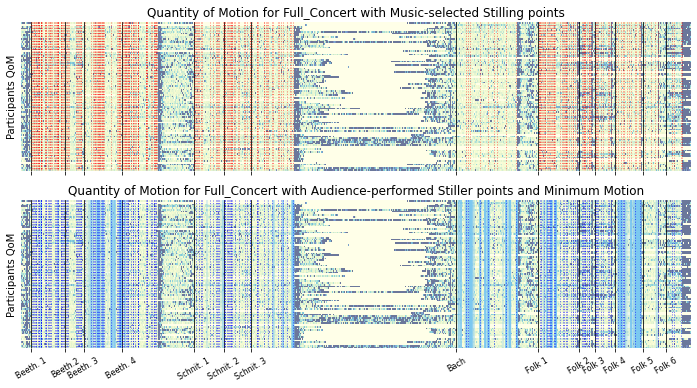

In [62]:
fig, (ax1,ax2) = plt.subplots(2, 1,figsize = [12,6])
chart = sns.heatmap(data=seg_df.transpose(), ax=ax1,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)
new_xticks = len(seg_df)*(Still_times.index - seg_start)/(seg_end-seg_start)

for i in range(len(new_xticks)):
    ax1.plot([new_xticks[i],new_xticks[i]],[0,90],':r',alpha=0.5,linewidth=1.0)

ax1.set_title('Quantity of Motion for ' + seg_tag + ' with Music-selected Stilling points')
Music_xticks = len(seg_df)*(seg_times['Time_s'] - seg_start)/(seg_end-seg_start)
ax1.set_xticks(Music_xticks)
ax1.set_xticklabels([])
ax1.tick_params(axis='x',grid_color='k',labelrotation=30)
ax1.grid()
ax1.set_ylabel('Participants QoM')
ax1.set_yticks([])

chart = sns.heatmap(data=seg_df.transpose(), ax=ax2,vmin=0, vmax=0.4,cbar=False, cmap="YlGnBu",alpha=0.6)

# the points already at or below the median low
new_xticks = len(seg_df)*(medianQM_Roll.loc[medianQM_Roll<Already_still_Thresh].index - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    ax2.plot([new_xticks[i],new_xticks[i]],[0,90],color='xkcd:lightblue',alpha=0.2)

# the points with significant decreases 
new_xticks = len(seg_df)*(Part_times.index - seg_start)/(seg_end-seg_start)
for i in range(len(new_xticks)):
    ax2.plot([new_xticks[i],new_xticks[i]],[0,90],':b',alpha=0.6,linewidth=1.0)

ax2.set_title('Quantity of Motion for ' + seg_tag + ' with Audience-performed Stiller points and Minimum Motion')
ax2.set_xticks(Music_xticks)
shorter_Tags = ['Beeth. 1', 'Beeth.2', 'Beeth. 3', 'Beeth. 4','Schnit. 1', 'Schnit. 2', 'Schnit. 3','Bach','Folk 1', 'Folk 2', 'Folk 3','Folk 4','Folk 5', 'Folk 6']
ax2.set_xticklabels(shorter_Tags,fontsize=8) #seg_times.Event) , ha='right'
ax2.tick_params(axis='x',grid_color='k',labelrotation=30)
ax2.grid()
ax2.set_ylabel('Participants QoM')
ax2.set_yticks([])
plt.savefig('./plots/Hall_qom_More_stilledpoints.png',bbox_inches = 'tight',dpi = 300)
plt.savefig('./plots/Fig7_Stilling_Stiller_Stilled_QoM',bbox_inches = 'tight',dpi = 300)
plt.show()

## Analysis 3: Participation in Stillings
    Stilling participation rates: Distribution across participants per section
    Correlations across participants per section

In [63]:
seg_tag = 'Full_Concert'
seg_start = Main_concert_times.iloc[5,0]
seg_end = Main_concert_times.iloc[53,0]
seg_times = Main_concert_times.loc[Main_concert_times['Event_Type'].isin(['Music']),:]
[seg_start,seg_end ]
seg_df = aud_df.loc[seg_start:seg_end].copy()


In [64]:
drop_df = aud_df.rolling(10,center=True).mean().shift(periods=0-3) - aud_df.rolling(10,center=True).mean().shift(periods=28-3) #1 second average, reported at end of window
k_df = drop_df.loc[np.round(Still_times.index,1),:].copy()#.fillna(0)
# check=pd.DataFrame(index=k_df.index)
k_df=k_df.mask(k_df>=0, 0)
k_df=k_df.mask(k_df<0, 1)

[123.52941176470588, 61, 0.7176470588235294, 0.6070038910505836]


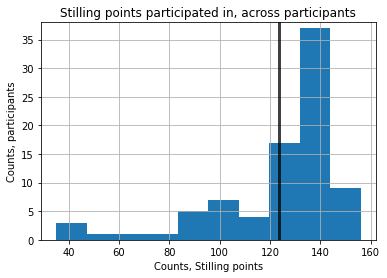

In [65]:
pc = k_df.sum(axis=0)
pc.hist()
# if participation was random, we expect the average participation rate would be 124 
thresh = k_df.sum().sum()/len(k_df.columns)
print([thresh, (pc>thresh).sum(), (pc>thresh).sum()/len(pc), pc.max()/len(k_df)])

plt.plot(thresh*np.array([1.0,1.0]),[0,40],'k',linewidth=3,alpha=0.75)
plt.title('Stilling points participated in, across participants') 
plt.ylabel('Counts, participants')
plt.xlabel('Counts, Stilling points')
plt.ylim([0,38])
plt.savefig('./plots/Stillings_Participation_Counts.png',dpi = 300)
plt.savefig('./plots/Fig8_Stillings_Participation_Counts.pdf',bbox_inches = 'tight',dpi = 300)

plt.show()
# most more than half

In [66]:
co_stillings = pd.DataFrame(index = k_df.columns)

tag = 'Full Concert'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[53,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print([len(sub_k),(sub_k.isna().sum()==len(sub_k)).sum()])
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)
co_stillings.loc[sub_k.isna().sum()==len(sub_k),tag] = np.nan

tag = 'Beethoven'
seg_start = Main_concert_times.iloc[8,0]
seg_end = Main_concert_times.iloc[12,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print([len(sub_k),(sub_k.isna().sum()==len(sub_k)).sum()])
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)
co_stillings.loc[sub_k.isna().sum()==len(sub_k),tag] = np.nan

tag = 'Schnittke'
seg_start = Main_concert_times.iloc[17,0]
seg_end = Main_concert_times.iloc[20,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print([len(sub_k),(sub_k.isna().sum()==len(sub_k)).sum()])
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)
co_stillings.loc[sub_k.isna().sum()==len(sub_k),tag] = np.nan


tag = 'Bach'
seg_start = Main_concert_times.iloc[28,0]
seg_end = Main_concert_times.iloc[29,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print([len(sub_k),(sub_k.isna().sum()==len(sub_k)).sum()])
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)
co_stillings.loc[sub_k.isna().sum()==len(sub_k),tag] = np.nan


tag = 'Folk'
seg_start = Main_concert_times.iloc[33,0]
seg_end = Main_concert_times.iloc[51,0]
sub_k = k_df.loc[seg_start:seg_end,:]
print([len(sub_k),(sub_k.isna().sum()==len(sub_k)).sum()])
co_stillings[tag] = sub_k.sum(axis=0)/len(sub_k)
co_stillings.loc[sub_k.isna().sum()==len(sub_k),tag] = np.nan

co_stillings

[257, 0]
[120, 3]
[54, 7]
[9, 7]
[74, 7]


,Full Concert,Beethoven,Schnittke,Bach,Folk
ADQ001,0.447471,0.583333,NaN,0.666667,0.527027
ADQ002,0.163424,NaN,NaN,0.333333,0.527027
ADQ003,0.544747,0.558333,0.481481,0.666667,0.554054
ADQ004,0.529183,0.491667,0.500000,0.666667,0.594595
ADQ005,0.486381,0.483333,0.425926,0.666667,0.513514
...,...,...,...,...,...
AEQ086,0.163424,NaN,NaN,0.777778,0.472973
AEQ087,0.552529,0.483333,0.555556,0.666667,0.648649
AEQ088,0.513619,0.541667,0.444444,0.777778,0.486486
AEQ089,0.509728,0.566667,0.425926,0.333333,0.500000


In [67]:
# stillings
cols = co_stillings.columns
a = pd.DataFrame(index = cols, columns = cols)
b = pd.DataFrame(index = cols, columns = cols)

for c in cols:
    C = co_stillings.loc[co_stillings.loc[:,c].notna(),c]
    for d in cols:
        D = co_stillings.loc[co_stillings.loc[:,d].notna(),d]
        C.index.intersection(D.index)
        r,p = sp.stats.pearsonr(co_stillings.loc[C.index.intersection(D.index),c],co_stillings.loc[C.index.intersection(D.index),d])
        #print([c,d,p ])
        a.loc[c,d] = r
        b.loc[c,d] = p

a 

,Full Concert,Beethoven,Schnittke,Bach,Folk
Full Concert,1.0,0.596585,0.504426,0.191672,0.494377
Beethoven,0.596585,1.0,0.147557,0.243825,0.293104
Schnittke,0.504426,0.147557,1.0,0.019515,0.253772
Bach,0.191672,0.243825,0.019515,1.0,-0.012532
Folk,0.494377,0.293104,0.253772,-0.012532,1.0


In [68]:
b

,Full Concert,Beethoven,Schnittke,Bach,Folk
Full Concert,0.0,0.0,0.000002,0.092745,0.000004
Beethoven,0.0,0.0,0.197324,0.035027,0.010709
Schnittke,0.000002,0.197324,0.0,0.87075,0.031477
Bach,0.092745,0.035027,0.87075,0.0,0.91386
Folk,0.000004,0.010709,0.031477,0.91386,0.0
